# CNN Network for Music Classification

## Importing Libraries and Dataset

In [ ]:
from google.colab import drive
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import cv2
import random
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from keras import backend as K
from IPython.display import display, HTML
drive.mount('/content/drive')

Mounted at /content/drive


## Data Collection/ Preprocessing

##### **STEP 1: Spectrogram Creation (10 Second Segments)**

Run only once!

* This code operates on a set of MIDI files located within a designated directory and its subfolders. It calculates and synthesizes audio from these MIDI files, subsequently dividing the audio into segments of predefined duration. For each segment, it computes a Short-Time Fourier Transform (STFT) to generate a spectrogram, representing audio frequency content over time. The resulting spectrogram images are then organized by composer, with each composer having a dedicated output folder. The code iterates through the MIDI files, extracts composer information from folder paths, and saves individual spectrogram images in JPEG format, using filenames that incorporate composer names, file numbers, and segment numbers. Existing image files are skipped, and the process is carried out efficiently for multiple segments and MIDI files.

In [ ]:
# # Specify the path to the main folder containing the subfolders with MIDI files
# main_folder_path = '/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/NN_midi_files_extended/train/byrd'

# # Specify the path to the folder where you want to save the JPEG files
# output_folder_path = '/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5 Log Scaled'

# SEGMENT_DURATION_SEC = 10
# SAMPLES_PER_SEGMENT = SEGMENT_DURATION_SEC * 44100

# for root, dirs, files in os.walk(main_folder_path):
#     for file_number, filename in enumerate(files, 1):  # Enumerate to get file_number
#         if filename.lower().endswith('.mid') or filename.lower().endswith('.midi'):
#             midi_file_path = os.path.join(root, filename)
#             composer_name = os.path.basename(root)
#             composer_output_folder = os.path.join(output_folder_path, composer_name)
#             os.makedirs(composer_output_folder, exist_ok=True)

#             midi_data = pretty_midi.PrettyMIDI(midi_file_path)
#             audio_data = midi_data.synthesize(fs=44100)
#             audio_data = audio_data.astype(np.float32)
#             audio_data /= np.max(np.abs(audio_data))

#             num_segments = int(len(audio_data) / SAMPLES_PER_SEGMENT)

#             for segment_num in range(num_segments):
#                 start_sample = segment_num * SAMPLES_PER_SEGMENT
#                 end_sample = start_sample + SAMPLES_PER_SEGMENT

#                 segment_audio = audio_data[start_sample:end_sample]

#                 # Compute the STFT
#                 D = librosa.stft(segment_audio)

#                 # Plot and save
#                 fig, ax = plt.subplots(figsize=(14, 10))
#                 img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
#                                                y_axis='log', x_axis='time', ax=ax)
#                 ax.axis('off')

#                 # Naming the output as "composername_filenumber_segmentnumber.jpg"
#                 output_filename = f'{composer_name}_{file_number}_{segment_num + 1}.jpg'
#                 output_filepath = os.path.join(composer_output_folder, output_filename)

#                 if os.path.exists(output_filepath):
#                     print(f'Skipping {midi_file_path} - Segment {segment_num + 1} as JPEG file already exists.')
#                     continue

#                 plt.savefig(output_filepath, bbox_inches='tight', pad_inches=0)
#                 plt.close()

##### **View Spectrogram Data Check**
* This code selects a random JPEG image file from the specified folder path, loads and resizes the image, and displays the resized image along with its filename using HTML formatting.

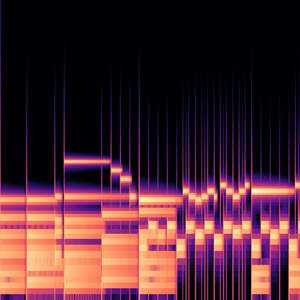

In [ ]:
# Path to the folder containing the generated JPEG files
image_folder_path = '/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5/mozart'

# List all image files in the folder
image_files = [file for file in os.listdir(image_folder_path) if file.lower().endswith('.jpg')]

# Randomly select an image filename
random_image_filename = random.choice(image_files)

# Construct the full path to the randomly selected image
random_image_path = os.path.join(image_folder_path, random_image_filename)

# Load the randomly selected image using PIL
random_loaded_image = Image.open(random_image_path)

# Resize the image to a smaller size (e.g., 300x300)
smaller_image = random_loaded_image.resize((300, 300))

# Display the resized image and label with its filename
display(HTML(f"<p>Image filename: {random_image_filename}</p>"))
display(smaller_image)


##### **STEP 2: Preprocess All Test-Spectrogram Images to Greyscale + Resize (RUN ONLY ONCE)**

###### A: Import Spectrograms from Step 1
###### This code defines a function that collects image paths from subfolders in a given directory, classifying them based on customized labels and values specified in a label mapping. By traversing the directory structure, the code assigns images to composer categories using their filenames' prefixes and the provided label mapping. Images are grouped under custom labels, enabling flexible customization of classification. The resulting image paths and their associated custom labels are compiled into separate lists, facilitating further analysis and processing.


In [ ]:
def label_images(root_folder):
    # Initialize dict for composers and their images
    labeled_dict = {
        'Bach': [],
        'Bartok': [],
        'Byrd': [],
        'Chopin': [],
        'Handel': [],
        'Hummel': [],
        'Mendelssohn': [],
        'Mozart': [],
        'Schumann': [],
        'Other': []
    }

        # Go through the files and get the name of each file
    for subdir, _, files in os.walk(root_folder):
        for filename in files:
            if filename.endswith(".jpg"):
                image_path = os.path.join(subdir, filename)

                # Extract the composer label from the filename and add the image_path to the appropriate list
                if filename.startswith('bach'):
                    labeled_dict['Bach'].append(image_path)
                elif filename.startswith('bartok'):
                    labeled_dict['Bartok'].append(image_path)
                elif filename.startswith('byrd'):
                    labeled_dict['Byrd'].append(image_path)
                elif filename.startswith('chopin'):
                    labeled_dict['Chopin'].append(image_path)
                elif filename.startswith('handel'):
                    labeled_dict['Handel'].append(image_path)
                elif filename.startswith('hummel'):
                    labeled_dict['Hummel'].append(image_path)
                elif filename.startswith('mendelssohn'):
                    labeled_dict['Mendelssohn'].append(image_path)
                elif filename.startswith('mozart'):
                    labeled_dict['Mozart'].append(image_path)
                elif filename.startswith('schumann'):
                    labeled_dict['Schumann'].append(image_path)
                else:
                    labeled_dict['Other'].append(image_path)

    # Now we will sample 1000 from each category
    sampled_images = []
    sampled_labels = []
    for label, images in labeled_dict.items():
        if len(images) > 1000:  # If we have more than 1000 images, sample them
            sampled = random.sample(images, 1000)
        else:  # Otherwise, take them all
            sampled = images

        # Append to our final lists
        sampled_images.extend(sampled)
        sampled_labels.extend([label] * len(sampled))

    return sampled_images, sampled_labels

# Call function
spectrogram_folder = '/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5'
labeled_images, labels = label_images(spectrogram_folder)

# Sanity checks
print("Number of spectrograms:", len(labeled_images))
print("Number of labels:", len(labels))
print(labels)

Number of spectrograms: 8572
Number of labels: 8572
['Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Bach', 'Ba

It looks like we have an even length of labels and composers so we are good to continue! The labels also look in order to how they are called.

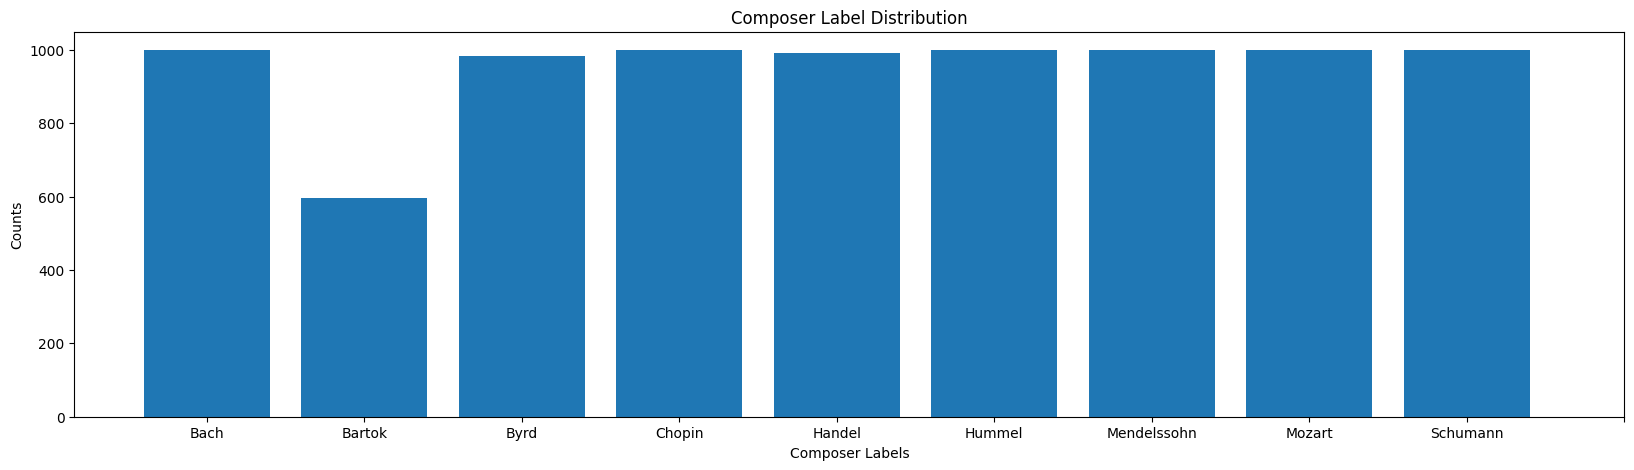

In [ ]:
# Counting values in labels list
label_counts = Counter(labels)
# Getting unique composers
unique_labels, counts = zip(*label_counts.items())

# Plotting
plt.figure(figsize=(20, 5))
plt.bar(unique_labels, counts)
plt.xlabel('Composer Labels')
plt.xticks(np.arange(0, len(counts)+1, 1))
plt.ylabel('Counts')
plt.title('Composer Label Distribution')
plt.show()

It looks like Bartok has a much lower count of spectrograms than others. Weights may need to be adjusted for Bartok in our final model or some other method to increase classification must be explored.

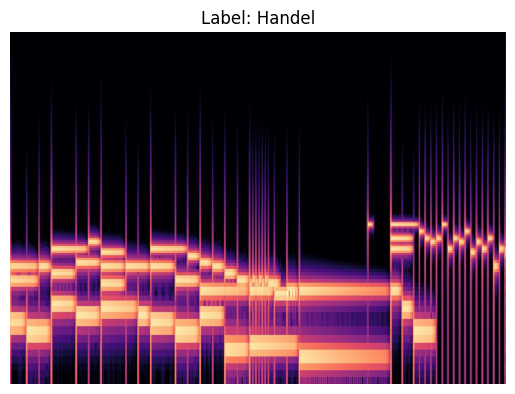

In [ ]:
# A function to plot random pictures to check if labels are correct
def plot_random_images(labeled_images, labels, num_images):
    # Get random integers for calling the image
    rand_numbers = random.sample(range(len(labeled_images)), num_images)
    for i in rand_numbers:
        image_loc = labeled_images[i]
        label = labels[i]
        image = Image.open(image_loc)
        plt.figure()
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

# Display 1 random images with their labels
plot_random_images(labeled_images, labels, num_images=1)

###### **Prerocess: Greyscale and Resize Images to 256x256 (RUN ONLY ONCE!)**

In [ ]:
def resize_greyscale_images(images, target_size):
    """
    Resizes a list of images to a specified target size and converts them to greyscale.
    Args:
        images (list): List of image file paths.
        target_size (tuple): Target size for resizing images (width, height).
    Returns:
        list: List of resized and greyscaled images.
    """
    resized_images = []
    for image_path in images:
        # Read image
        image = cv2.imread(image_path)
        # Resize
        resized_image = cv2.resize(image, target_size)
        # Convert the image to greyscale
        greyscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        # Add to new list of images
        resized_images.append(greyscale_image)
        #resized_images.append(resized_image) -- if take out greyscale_image
    return resized_images

In [ ]:
def plot_greyscale_resize(labeled_images, labels, num_images):
    """
    Plots a specified number of random greyscaled images from a list along with their labels.

    Args:
        labeled_images (list): List of greyscaled image arrays.
        labels (list): List of image labels.
        num_images (int): Number of images to plot.
    """
    # Generate a list of random indices to select random images
    random_indices = random.sample(range(len(labeled_images)), num_images)

    # Get random integers for calling the image
    for i in random_indices:
        image_array = labeled_images[i]
        label = labels[i]

        # Convert back to image
        image = Image.fromarray(image_array)

        # Plot
        plt.figure()
        # Set colormap to gray
        plt.imshow(image, cmap='gray')
        #plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

Preprocess (RUN ONLY ONCE)

In [ ]:
# # target size (width,height)
# target_size = (256, 256)

# # Call function to resize images and convert them to greyscale
# greyscale_images = resize_greyscale_images(labeled_images, target_size)

# # Display 5 random greyscaled images with their labels
# plot_greyscale_resize(greyscale_images, labels, num_images=5)

###### Export the Greyscaled/Resized Images (RUN ONCE)

In [ ]:
# def export_greyscale_images_to_drive(greyscale_images, original_image_paths, save_path):
#     for index, image_array in enumerate(greyscale_images):
#         # Extract original filename from path
#         filename = os.path.basename(original_image_paths[index])
#         # Define the save location using the provided path and original filename
#         save_location = os.path.join(save_path, filename)
#         # Save the greyscale image
#         cv2.imwrite(save_location, image_array)

# # Define Google Drive save path
# save_path = "/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/Test-SpectrogramsV5 GreyScaled & Resized"

# # Export the greyscale images to the specified Google Drive path
# export_greyscale_images_to_drive(greyscale_images, labeled_images, save_path)

###### Import the Images back in

In [ ]:
# spectrogram_folder = "/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5 GreyScaled & Resized"
spectrogram_folder = "/content/drive/MyDrive/AAI 511 Project Group ~3/Data/SpectrogramsV5 GreyScaled & Resized"
spectrogram_files = os.listdir(spectrogram_folder)
print(len(os.listdir(spectrogram_folder)))
print(os.listdir(spectrogram_folder))

8572
['schumann_13_100.jpg', 'schumann_24_3.jpg', 'schumann_18_22.jpg', 'schumann_8_2.jpg', 'schumann_29_17.jpg', 'schumann_13_94.jpg', 'schumann_5_29.jpg', 'schumann_7_137.jpg', 'schumann_7_100.jpg', 'schumann_13_70.jpg', 'schumann_7_25.jpg', 'schumann_25_24.jpg', 'schumann_24_9.jpg', 'schumann_25_36.jpg', 'schumann_25_29.jpg', 'schumann_36_75.jpg', 'schumann_30_16.jpg', 'schumann_15_3.jpg', 'schumann_19_12.jpg', 'schumann_16_6.jpg', 'schumann_25_68.jpg', 'schumann_18_88.jpg', 'schumann_7_67.jpg', 'schumann_18_117.jpg', 'schumann_13_15.jpg', 'schumann_13_59.jpg', 'schumann_25_61.jpg', 'schumann_7_70.jpg', 'schumann_38_79.jpg', 'schumann_34_35.jpg', 'schumann_5_47.jpg', 'schumann_18_11.jpg', 'schumann_20_13.jpg', 'schumann_2_37.jpg', 'schumann_7_7.jpg', 'schumann_13_45.jpg', 'schumann_13_35.jpg', 'schumann_7_49.jpg', 'schumann_5_19.jpg', 'schumann_37_6.jpg', 'schumann_26_4.jpg', 'schumann_5_79.jpg', 'schumann_24_20.jpg', 'schumann_12_1.jpg', 'schumann_2_5.jpg', 'schumann_19_10.jpg', 's

In [ ]:
def label_images(images):
    # Initialize lists for labels and images
    labels = []
    labeled_images = []
    # Go through the files and get the name of each file
    for filename in os.listdir(images):
        if filename.endswith(".jpg"):
            image_path = os.path.join(images, filename)
            # Extract the composer label from the filename
            if filename.startswith('bach'):
                labels.append('Bach')
            elif filename.startswith('bartok') or filename.startswith('bartok'):
                labels.append('Bartok')
            elif filename.startswith('byrd'):
                labels.append('Byrd')
            elif filename.startswith('chopin'):
                labels.append('Chopin')
            elif filename.startswith('handel'):
                labels.append('Handel')
            elif filename.startswith('hummel'):
                labels.append('Hummel')
            elif filename.startswith('mendelssohn'):
                labels.append('Mendelssohn')
            elif filename.startswith('mozart'):
                labels.append('Mozart')
            elif filename.startswith('schumann'):
                labels.append('Schumann')
            else:
              labels.append('Other')
            # Append the labeled image path to the list
            labeled_images.append(image_path)
    return labeled_images, labels
labeled_images, labels = label_images(spectrogram_folder)

Our team had to rescale and greyscale images on different computers due to hardware constraints. The converted images are then brought back in again for the modeling process already resized and greyscaled.

In [ ]:
# Sanity Checks
print("Number of spectrograms:", len(labeled_images))
print("Number of labels:", len(labels))
print(labels)

Number of spectrograms: 8572
Number of labels: 8572
['Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann', 'Schumann',

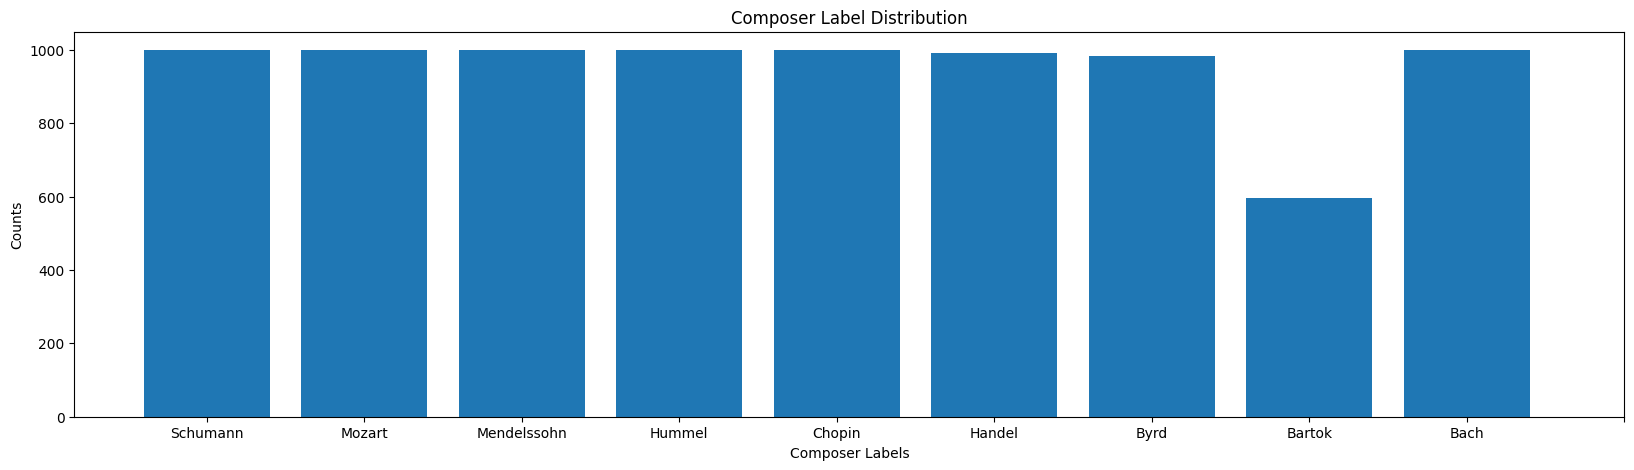

In [ ]:
# Counting values in labels list
label_counts = Counter(labels)
# Getting unique composers
unique_labels, counts = zip(*label_counts.items())

# Plotting
plt.figure(figsize=(20, 5))
plt.bar(unique_labels, counts)
plt.xlabel('Composer Labels')
plt.xticks(np.arange(0, len(counts)+1, 1))
plt.ylabel('Counts')
plt.title('Composer Label Distribution')
plt.show()

Bartok is the lowest count still, but it makes sense because he had the least amount of data.

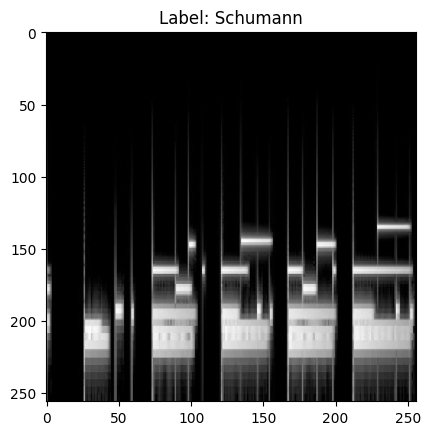

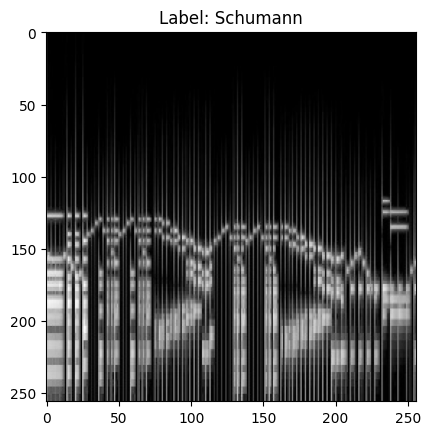

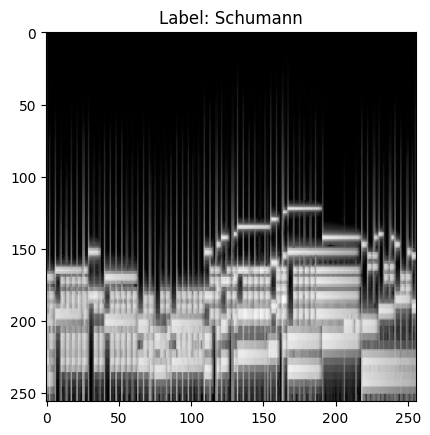

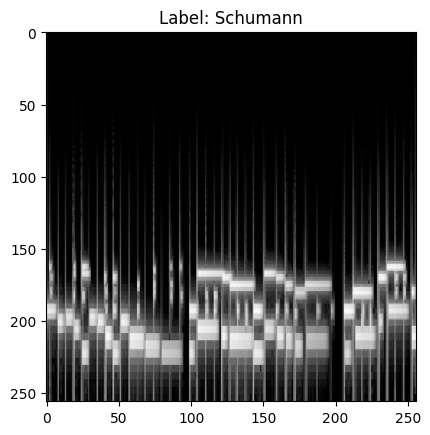

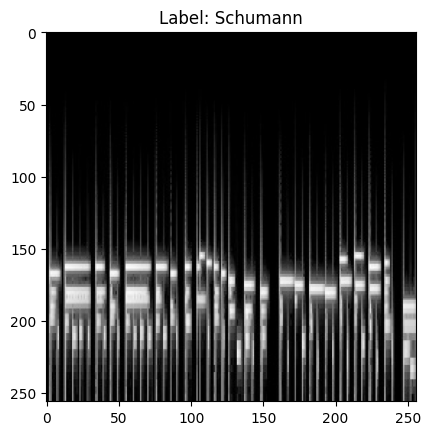

In [ ]:
# A function to show some leaves to check if labels are correct
def plot_images(labeled_images, labels, num_images):
    for i in range(num_images):
        # Get the location of correct label
        image_loc = labeled_images[i]
        label = labels[i]
        image = Image.open(image_loc)
        plt.figure()
        plt.imshow(image, cmap = "gray")
        plt.title(f"Label: {label}")
        plt.show()

# Call function to plot images
plot_images(labeled_images, labels, num_images=5)

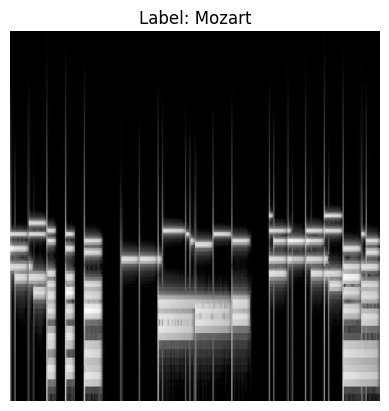

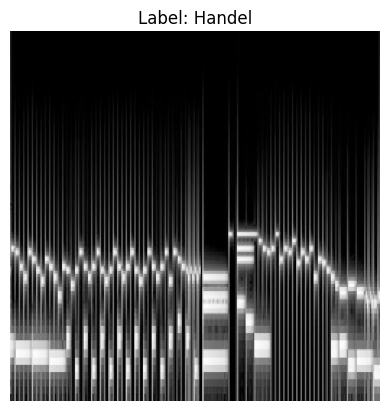

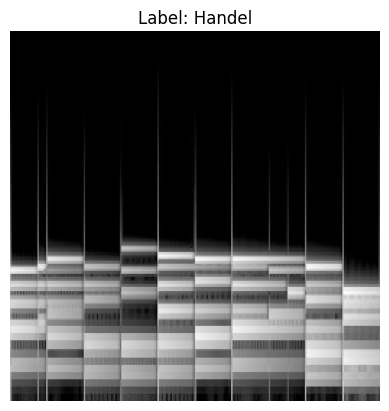

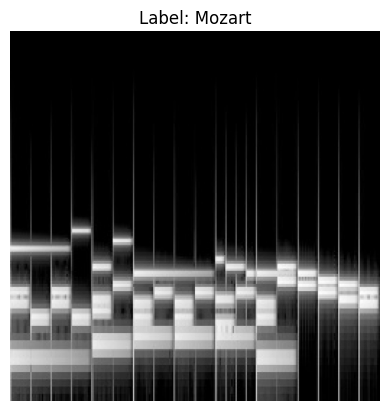

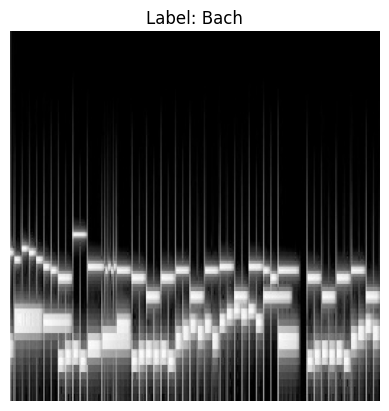

In [ ]:
# A function to plot random leaves to check if labels are correct
def plot_random_images(labeled_images, labels, num_images):
    # Get random integers for calling the image
    rand_numbers = random.sample(range(len(labeled_images)), num_images)
    for i in rand_numbers:
        image_loc = labeled_images[i]
        label = labels[i]
        image = Image.open(image_loc)
        plt.figure()
        plt.imshow(image, cmap = "gray")
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

# Display 5 random images with their labels
plot_random_images(labeled_images, labels, num_images=5)

##### End of Preprocessing ^^

In [ ]:
len(os.listdir(spectrogram_folder))

8572

In [ ]:
print(os.listdir(spectrogram_folder))

['schumann_13_100.jpg', 'schumann_24_3.jpg', 'schumann_18_22.jpg', 'schumann_8_2.jpg', 'schumann_29_17.jpg', 'schumann_13_94.jpg', 'schumann_5_29.jpg', 'schumann_7_137.jpg', 'schumann_7_100.jpg', 'schumann_13_70.jpg', 'schumann_7_25.jpg', 'schumann_25_24.jpg', 'schumann_24_9.jpg', 'schumann_25_36.jpg', 'schumann_25_29.jpg', 'schumann_36_75.jpg', 'schumann_30_16.jpg', 'schumann_15_3.jpg', 'schumann_19_12.jpg', 'schumann_16_6.jpg', 'schumann_25_68.jpg', 'schumann_18_88.jpg', 'schumann_7_67.jpg', 'schumann_18_117.jpg', 'schumann_13_15.jpg', 'schumann_13_59.jpg', 'schumann_25_61.jpg', 'schumann_7_70.jpg', 'schumann_38_79.jpg', 'schumann_34_35.jpg', 'schumann_5_47.jpg', 'schumann_18_11.jpg', 'schumann_20_13.jpg', 'schumann_2_37.jpg', 'schumann_7_7.jpg', 'schumann_13_45.jpg', 'schumann_13_35.jpg', 'schumann_7_49.jpg', 'schumann_5_19.jpg', 'schumann_37_6.jpg', 'schumann_26_4.jpg', 'schumann_5_79.jpg', 'schumann_24_20.jpg', 'schumann_12_1.jpg', 'schumann_2_5.jpg', 'schumann_19_10.jpg', 'schuma

### DEPRECATE Get 500 random jpg from each composer (old code)

In [ ]:
# import os

# import random

# def label_images(root_folder):
#     # Initialize dictionary for labels and their respective images
#     labeled_dict = {
#         'Bach': [],
#         'Bartok': [],
#         'Byrd': [],
#         'Chopin': [],
#         'Handel': [],
#         'Hummel': [],
#         'Mendelssohn': [],
#         'Mozart': [],
#         'Schumann': [],
#         'Other': []
#     }

#     # Go through the files and get the name of each file
#     for subdir, _, files in os.walk(root_folder):
#         for filename in files:
#             if filename.endswith(".jpg"):
#                 image_path = os.path.join(subdir, filename)

#                 # Extract the composer label from the filename and add the image_path to the appropriate list
#                 if filename.startswith('bach'):
#                     labeled_dict['Bach'].append(image_path)
#                 elif filename.startswith('bartok'):
#                     labeled_dict['Bartok'].append(image_path)
#                 elif filename.startswith('byrd'):
#                     labeled_dict['Byrd'].append(image_path)
#                 elif filename.startswith('chopin'):
#                     labeled_dict['Chopin'].append(image_path)
#                 elif filename.startswith('handel'):
#                     labeled_dict['Handel'].append(image_path)
#                 elif filename.startswith('hummel'):
#                     labeled_dict['Hummel'].append(image_path)
#                 elif filename.startswith('mendelssohn'):
#                     labeled_dict['Mendelssohn'].append(image_path)
#                 elif filename.startswith('mozart'):
#                     labeled_dict['Mozart'].append(image_path)
#                 elif filename.startswith('schumann'):
#                     labeled_dict['Schumann'].append(image_path)
#                 else:
#                     labeled_dict['Other'].append(image_path)

#     # Now we will sample 1000 from each category
#     sampled_images = []
#     sampled_labels = []
#     for label, images in labeled_dict.items():
#         if len(images) > 1000:  # If we have more than 1000 images, sample them
#             sampled = random.sample(images, 1000)
#         else:  # Otherwise, take them all
#             sampled = images

#         # Append to our final lists
#         sampled_images.extend(sampled)
#         sampled_labels.extend([label] * len(sampled))

#     return sampled_images, sampled_labels

# spectrogram_folder = '/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5/'
# labeled_images, labels = label_images(spectrogram_folder)


### DEPRECATE Sanity Checks and Graphical Analysis

In [ ]:
# print("Number of spectrograms:", len(labeled_images))
# print("Number of labels:", len(labels))

In [ ]:
# print(labels)

In [ ]:
# # Counting values in labels list
# label_counts = Counter(labels)
# #
# unique_labels, counts = zip(*label_counts.items())

# # Plotting
# plt.figure(figsize=(20, 5))
# plt.bar(unique_labels, counts)
# plt.xlabel('Composer Labels')
# plt.xticks(np.arange(0, len(counts)+1, 1))
# plt.ylabel('Counts')
# plt.title('Composer Label Distribution')
# plt.show()

In [ ]:
# # A function to show some leaves to check if labels are correct
# def plot_images(labeled_images, labels, num_images):
#     for i in range(num_images):
#         # Get the location of correct label
#         image_loc = labeled_images[i]
#         label = labels[i]
#         image = Image.open(image_loc)
#         plt.figure()
#         plt.imshow(image, cmap = 'gray')
#         plt.title(f"Label: {label}")
#         plt.show()

# # Call function to plot images
# plot_images(labeled_images, labels, num_images=5)

In [ ]:
# # A function to plot random leaves to check if labels are correct
# def plot_random_images(labeled_images, labels, num_images):
#     # Get random integers for calling the image
#     rand_numbers = random.sample(range(len(labeled_images)), num_images)
#     for i in rand_numbers:
#         image_loc = labeled_images[i]
#         label = labels[i]
#         image = Image.open(image_loc)
#         plt.figure()
#         plt.imshow(image)
#         #plt.title(f"Label: {label}")
#         plt.axis('off')
#         plt.show()

# # Display 5 random images with their labels
# plot_random_images(labeled_images, labels, num_images=5)

### DEPRECATE Greyscaling and Resizing (old code)

In [ ]:
# def resize_greyscale_images(images, target_size):
#     resized_images = []
#     for image_path in images:
#         # Read image
#         image = cv2.imread(image_path)
#         # Resize
#         resized_image = cv2.resize(image, target_size)
#         # Convert the image to greyscale
#         greyscale_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
#         # Add to new list of images
#         resized_images.append(greyscale_image)
#         #resized_images.append(resized_image) -- if take out greyscale_image
#     return resized_images

# # target size (width,height)
# target_size = (256, 256)

# # Call function to resize images and greyscale them
# greyscale_images = resize_greyscale_images(labeled_images, target_size)

In [ ]:
# import os

# def export_greyscale_images_to_drive(greyscale_images, original_image_paths, save_path):
#     for index, image_array in enumerate(greyscale_images):
#         # Extract original filename from path
#         filename = os.path.basename(original_image_paths[index])
#         # Define the save location using the provided path and original filename
#         save_location = os.path.join(save_path, filename)
#         # Save the greyscale image
#         cv2.imwrite(save_location, image_array)

# # Process your images to greyscale
# #greyscale_images = resize_greyscale_images(labeled_images, target_size)

# # Define Google Drive save path
# save_path = "/content/drive/MyDrive/AA USD/AI 511 Deep Learning/AAI 511 Project Group ~3/Data/SpectrogramsV5 GreyScaled & Resized"

# # Export the greyscale images to the specified Google Drive path
# export_greyscale_images_to_drive(greyscale_images, labeled_images, save_path)


In [ ]:
# def plot_greyscale_resize(labeled_images, labels, num_images):
#     # Generate a list of random indices to select random images
#     random_indices = random.sample(range(len(labeled_images)), num_images)
#     # Get random integers for calling the imaage
#     for i in random_indices:
#         image_array = labeled_images[i]
#         label = labels[i]
#         # Convert back to image
#         image = Image.fromarray(image_array)
#         # plot
#         plt.figure()
#         # Cmap has to be grey
#         plt.imshow(image, cmap='gray')
#         #plt.title(f"Label: {label}")
#         plt.axis('off')
#         plt.show()

# # Display 5 random greyscale images with their labels
# plot_greyscale_resize(greyscale_images, labels, num_images=5)

NameError: ignored

## Model Building

In order for the model to take the input we must map the composers and one-hot encode this information.

In [ ]:
composers = ['Bach', 'Bartok', 'Byrd', 'Chopin', 'Handel', 'Hummel', 'Mendelssohn', 'Mozart', 'Schumann']
label_mapping = {composer: index for index, composer in enumerate(composers)}

# Convert the string labels to numeric labels using the mapping
numeric_labels = [label_mapping[label] for label in labels]

# One-hot encode the numeric labels
num_classes = len(composers)
one_hot_labels = to_categorical(numeric_labels, num_classes=num_classes)

In [ ]:
print(one_hot_labels.shape)

(8572, 9)


In [ ]:
print(one_hot_labels[:5])

[[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
for original_label, one_hot_label in zip(labels[:5], one_hot_labels[:5]):
    print(f"Original label: {original_label} - One-hot encoded label: {one_hot_label}")

Original label: Schumann - One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: Schumann - One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: Schumann - One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: Schumann - One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1.]
Original label: Schumann - One-hot encoded label: [0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
if len(np.shape(labeled_images[0])) == 2:
    print("2d array")
else:
    print("not a 2d array")

not a 2d array


We must convert these images to a 2D array so that the model can take them as an input.

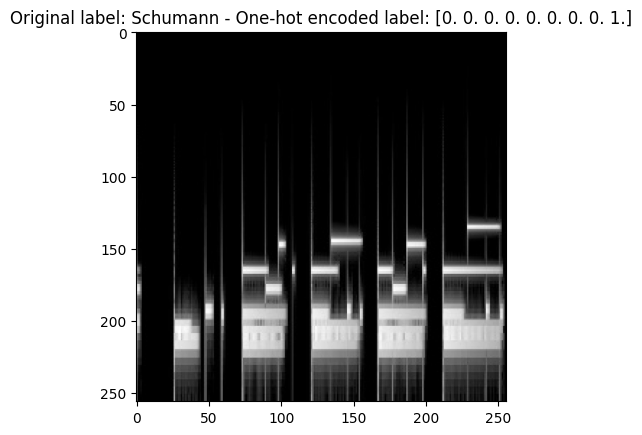

In [ ]:
# Read the first image from its file path
first_image_path = labeled_images[0]
first_image = cv2.imread(first_image_path, cv2.IMREAD_GRAYSCALE)

# Display the image
plt.imshow(first_image, cmap='gray')
plt.title(f"Original label: {labels[0]} - One-hot encoded label: {one_hot_labels[0]}")
plt.show()

In [ ]:
print(one_hot_labels.sum(axis=0))

[1000.  596.  984. 1000.  992. 1000. 1000. 1000. 1000.]


Bartok only has 596 but the rest of the composers have close to 1000 10-second intervals.

In [ ]:
train_size = 0.7
test_val_size = (1 - train_size) / 2

# Split into training and temporary test/validation sets
image_train, image_split, labels_train, labels_split = train_test_split(labeled_images, one_hot_labels, test_size=(1 - train_size), stratify=one_hot_labels)

# Split the temporary test/validation sets into separate test and validation sets
image_val, image_test, labels_val, labels_test = train_test_split(image_split, labels_split, test_size=0.5, stratify=labels_split)

print(f"Train images: {len(image_train)}")
print(f"Train labels: {len(labels_train)}")
print(f"Validation images: {len(image_val)}")
print(f"Validation labels: {len(labels_val)}")
print(f"Test images: {len(image_test)}")
print(f"Test labels: {len(labels_test)}")

Train images: 6000
Train labels: 6000
Validation images: 1286
Validation labels: 1286
Test images: 1286
Test labels: 1286


In [ ]:
# This code converts spectrograms into 2D arrays using multithreading
from joblib import Parallel, delayed

def read_and_normalize_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image / 255.0

def read_and_normalize_images(image_paths):
    images = Parallel(n_jobs=-1)(delayed(read_and_normalize_image)(image_path) for image_path in image_paths)
    return np.array(images)
image_train = read_and_normalize_images(image_train)
image_val = read_and_normalize_images(image_val)
image_test = read_and_normalize_images(image_test)

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

## Old Attempts 1 - 8

## Kayla's Original Model - Accuracy: 58%, Precision: 56%, Recall 56%, F1: 56%

In [ ]:
#Original
# # Initialize the model
# model = Sequential()

# # Convolutional layers
# model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256, 1)))
# model.add(Conv2D(128, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(Conv2D(8, (3, 3)))
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.25))

# # Flatten the output
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))

# model.add(Dense(32))
# model.add(Dropout(0.5))

# model.add(Dense(9, activation='softmax'))

# # Print the summary of the model
# model.summary()


#New
# Initialize the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 128)     295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 128)     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 32)      18464     
                                                        

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from keras.regularizers import l2

# # Initialize the model
# model = Sequential()

# # First block
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
# model.add(BatchNormalization())
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.2))

# # Second block
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.3))

# # Third block
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D((2, 2)))
# model.add(Dropout(0.4))

# # Flatten the output
# model.add(Flatten())

# # Fully connected layers
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(9, activation='softmax'))

# # Print the summary of the model
# model.summary()


In [ ]:
print(image_train.shape)
print(labels_train.shape)

(6000, 256, 256, 1)
(6000, 9)


In [ ]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 32, validation_data=(image_val, labels_val))

Epoch 1/100
188/188 [==============================] - 140s 289ms/step - loss: 2.1755 - accuracy: 0.1370 - val_loss: 2.1126 - val_accuracy: 0.2216
Epoch 2/100
188/188 [==============================] - 17s 88ms/step - loss: 2.0427 - accuracy: 0.2258 - val_loss: 1.8640 - val_accuracy: 0.3375
Epoch 3/100
188/188 [==============================] - 16s 88ms/step - loss: 1.8983 - accuracy: 0.2893 - val_loss: 1.7727 - val_accuracy: 0.3639
Epoch 4/100
188/188 [==============================] - 16s 88ms/step - loss: 1.8392 - accuracy: 0.3103 - val_loss: 1.7385 - val_accuracy: 0.3888
Epoch 5/100
188/188 [==============================] - 16s 88ms/step - loss: 1.7772 - accuracy: 0.3410 - val_loss: 1.6905 - val_accuracy: 0.3608
Epoch 6/100
188/188 [==============================] - 16s 88ms/step - loss: 1.7411 - accuracy: 0.3520 - val_loss: 1.6621 - val_accuracy: 0.3725
Epoch 7/100
188/188 [==============================] - 16s 88ms/step - loss: 1.7097 - accuracy: 0.3785 - val_loss: 1.5885 - val_

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       150
           1       0.43      0.20      0.27        90
           2       0.78      0.97      0.87       147
           3       0.51      0.50      0.51       150
           4       0.56      0.64      0.60       149
           5       0.47      0.51      0.49       150
           6       0.57      0.50      0.53       150
           7       0.54      0.57      0.56       150
           8       0.49      0.48      0.48       150

    accuracy                           0.58      1286
   macro avg       0.56      0.56      0.56      1286
weighted avg       0.57      0.58      0.57      1286



### Version 2

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

datagen.fit(image_train)

In [ ]:
from keras.regularizers import l2
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='tanh', input_shape=(256, 256, 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='tanh'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.50))

model.add(Flatten())

model.add(Dense(64, activation='relu', kernel_regularizer = l2(0.001)))
model.add(Dropout(0.50))

model.add(Dense(32, activation='relu', kernel_regularizer = l2(0.001)))
model.add(Dropout(0.50))

model.add(Dense(9, activation='softmax'))

from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 7s 7ms/step - loss: 2.3406 - accuracy: 0.1250 - val_loss: 2.3177 - val_accuracy: 0.1462
Epoch 2/100
750/750 [==============================] - 5s 6ms/step - loss: 2.2956 - accuracy: 0.1515 - val_loss: 2.2552 - val_accuracy: 0.2395
Epoch 3/100
750/750 [==============================] - 5s 6ms/step - loss: 2.2530 - accuracy: 0.1847 - val_loss: 2.1877 - val_accuracy: 0.2628
Epoch 4/100
750/750 [==============================] - 5s 6ms/step - loss: 2.2178 - accuracy: 0.1975 - val_loss: 2.1494 - val_accuracy: 0.2776
Epoch 5/100
750/750 [==============================] - 5s 6ms/step - loss: 2.1865 - accuracy: 0.2105 - val_loss: 2.1121 - val_accuracy: 0.3017
Epoch 6/100
750/750 [==============================] - 5s 6ms/step - loss: 2.1698 - accuracy: 0.2180 - val_loss: 2.0832 - val_accuracy: 0.3126
Epoch 7/100
750/750 [==============================] - 5s 6ms/step - loss: 2.1382 - accuracy: 0.2372 - val_loss: 2.0584 - val_accuracy: 0.3281

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       150
           1       0.44      0.04      0.08        90
           2       0.77      0.92      0.84       147
           3       0.42      0.38      0.40       150
           4       0.60      0.66      0.63       149
           5       0.36      0.46      0.40       150
           6       0.43      0.52      0.47       150
           7       0.59      0.52      0.55       150
           8       0.38      0.41      0.39       150

    accuracy                           0.53      1286
   macro avg       0.52      0.51      0.49      1286
weighted avg       0.53      0.53      0.51      1286



## Attempt 2: Tuner - Accuracy: 45%, Recall: 44% , Precision: 45%, F1: 44%

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.regularizers import l2
import keras_tuner as kt

def build_model(hp):
    model = Sequential()

    # Conv block 1
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='tanh',
        input_shape=(256, 256, 1)))
    model.add(MaxPooling2D((2, 2)))

    # Conv block 2
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='tanh'))
    model.add(MaxPooling2D((2, 2)))

    # Conv block 3
    model.add(Conv2D(
        filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(9, activation='softmax'))

    optimizer = Adam(
        learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG', default=1e-3)
    )

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

# Stop training early
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Tuning the model
tuner.search(
    image_train, labels_train,
    epochs=300,
    validation_data=(image_val, labels_val),
    callbacks=[early_stop]
)

# Getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of filters in the first conv layer is {best_hps.get('conv_1_filters')} and
the optimal number of filters in the second conv layer is {best_hps.get('conv_2_filters')}.
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Trial 30 Complete [00h 01m 03s]
val_loss: 1.899215817451477

Best val_loss So Far: 1.6019397974014282
Total elapsed time: 00h 10m 34s

The optimal number of filters in the first conv layer is 96 and
the optimal number of filters in the second conv layer is 32.
The optimal learning rate for the optimizer is 7.989963064849984e-05.



In [ ]:
# Best parameters
best_params = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_params.values)

{'conv_1_filters': 96, 'conv_2_filters': 32, 'conv_3_filters': 128, 'dropout_1': 0.2, 'dropout_2': 0.1, 'dropout_3': 0.30000000000000004, 'learning_rate': 7.989963064849984e-05, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}


In [ ]:
# Model with tuned hyperparameters
tune_model = tuner.hypermodel.build(best_params)
tune_model.fit(image_train, labels_train,epochs = 300,verbose = 0)

In [ ]:
# Predict the model
labels_val_pred = tune_model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

22/22 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.59      0.80      0.68        75
           1       0.27      0.33      0.30        75
           2       0.78      0.93      0.85        75
           3       0.33      0.32      0.32        75
           4       0.59      0.55      0.57        75
           5       0.18      0.13      0.15        75
           6       0.52      0.21      0.30        75
           7       0.38      0.47      0.42        75
           8       0.35      0.33      0.34        75

    accuracy                           0.45       675
   macro avg       0.44      0.45      0.44       675
weighted avg       0.44      0.45      0.44       675



In [ ]:
accuracy = accuracy_score(labels_val_true, labels_val_pred)
precision = precision_score(labels_val_true, labels_val_pred, average='weighted')
recall = recall_score(labels_val_true, labels_val_pred, average='weighted')
f1 = f1_score(labels_val_true, labels_val_pred, average='weighted')
# Print the overall metrics
print("Accuracy Overall:", accuracy)
print("Precision Overall:", precision)
print("Recall Overall:", recall)
print("F1 Score Overall:", f1)

Accuracy Overall: 0.4533333333333333
Precision Overall: 0.4433607151251328
Recall Overall: 0.4533333333333333
F1 Score Overall: 0.4375339875348202


## Attempt 3: Accuracy: 58%, Recall: 58%, Precision: 58%, F1: 58%

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

(6000, 256, 256, 1)

In [ ]:
# Initialize the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(256, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(8, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Flatten the output
model.add(Flatten())

# Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32))
model.add(Dropout(0.5))

model.add(Dense(9, activation='softmax'))

# Print the summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 256)     2560      
                                                                 
 conv2d_10 (Conv2D)          (None, 252, 252, 128)     295040    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 126, 126, 128)    0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 126, 126, 128)     0         
                                                                 
 conv2d_11 (Conv2D)          (None, 124, 124, 64)      73792     
                                                                 
 conv2d_12 (Conv2D)          (None, 122, 122, 32)      18464     
                                                      

In [ ]:
from keras.optimizers import Adam
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 37s 25ms/step - loss: 2.1368 - accuracy: 0.1717 - val_loss: 2.0041 - val_accuracy: 0.2426
Epoch 2/100
750/750 [==============================] - 18s 24ms/step - loss: 1.9926 - accuracy: 0.2683 - val_loss: 1.8798 - val_accuracy: 0.3180
Epoch 3/100
750/750 [==============================] - 18s 24ms/step - loss: 1.8910 - accuracy: 0.3002 - val_loss: 1.7654 - val_accuracy: 0.3725
Epoch 4/100
750/750 [==============================] - 18s 24ms/step - loss: 1.8127 - accuracy: 0.3412 - val_loss: 1.6596 - val_accuracy: 0.4238
Epoch 5/100
750/750 [==============================] - 18s 24ms/step - loss: 1.7286 - accuracy: 0.3700 - val_loss: 1.6833 - val_accuracy: 0.4044
Epoch 6/100
750/750 [==============================] - 18s 24ms/step - loss: 1.6658 - accuracy: 0.3930 - val_loss: 1.7150 - val_accuracy: 0.4036
Epoch 7/100
750/750 [==============================] - 18s 24ms/step - loss: 1.5971 - accuracy: 0.4195 - val_loss: 1.5675 - val_ac

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 1s 26ms/step
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       150
           1       0.35      0.37      0.36        90
           2       0.80      0.97      0.88       147
           3       0.56      0.44      0.49       150
           4       0.58      0.69      0.63       149
           5       0.41      0.49      0.45       150
           6       0.66      0.54      0.59       150
           7       0.60      0.56      0.58       150
           8       0.48      0.41      0.44       150

    accuracy                           0.58      1286
   macro avg       0.57      0.57      0.57      1286
weighted avg       0.58      0.58      0.58      1286



## Attempt #4 VGG Architecture with AdaMax as optimizer - Accuracy: 60%, Precision: 59%, Recall: 60%, F1: 59%



In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

(6000, 256, 256, 1)

In [ ]:


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Initialize the model
model = Sequential()


# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Flatten the output
model.add(Flatten())


# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))  # for 9 classes

# Print the summary of the model
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 128)     147584    
                                                      

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 23s 25ms/step - loss: 2.1477 - accuracy: 0.1597 - val_loss: 1.9792 - val_accuracy: 0.3079
Epoch 2/100
750/750 [==============================] - 18s 24ms/step - loss: 1.8909 - accuracy: 0.3123 - val_loss: 1.7760 - val_accuracy: 0.3748
Epoch 3/100
750/750 [==============================] - 18s 24ms/step - loss: 1.7398 - accuracy: 0.3783 - val_loss: 1.6996 - val_accuracy: 0.3989
Epoch 4/100
750/750 [==============================] - 18s 24ms/step - loss: 1.6375 - accuracy: 0.4135 - val_loss: 1.5509 - val_accuracy: 0.4588
Epoch 5/100
750/750 [==============================] - 18s 24ms/step - loss: 1.5397 - accuracy: 0.4487 - val_loss: 1.4654 - val_accuracy: 0.4930
Epoch 6/100
750/750 [==============================] - 18s 24ms/step - loss: 1.4468 - accuracy: 0.4842 - val_loss: 1.5021 - val_accuracy: 0.4774
Epoch 7/100
750/750 [==============================] - 18s 24ms/step - loss: 1.3756 - accuracy: 0.5115 - val_loss: 1.3836 - val_ac

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       150
           1       0.47      0.39      0.42        90
           2       0.78      0.95      0.85       147
           3       0.52      0.60      0.56       150
           4       0.63      0.66      0.65       149
           5       0.56      0.43      0.48       150
           6       0.57      0.56      0.57       150
           7       0.66      0.55      0.60       150
           8       0.47      0.46      0.46       150

    accuracy                           0.60      1286
   macro avg       0.59      0.59      0.59      1286
weighted avg       0.59      0.60      0.59      1286



## Attempt #5 VGG16 Architecture with RMSProp - No improvement

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Initialize the model
model = Sequential()


# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


# Flatten the output
model.add(Flatten())


# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))  # for 9 classes

# Print the summary of the model
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 conv2d_23 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 128, 128, 64)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 128)     147584    
                                                      

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 23s 29ms/step - loss: 2.0611 - accuracy: 0.2167 - val_loss: 1.8401 - val_accuracy: 0.3678
Epoch 2/100
750/750 [==============================] - 21s 28ms/step - loss: 1.7407 - accuracy: 0.3673 - val_loss: 1.7186 - val_accuracy: 0.3857
Epoch 3/100
750/750 [==============================] - 21s 29ms/step - loss: 1.5531 - accuracy: 0.4422 - val_loss: 1.4476 - val_accuracy: 0.4650
Epoch 4/100
750/750 [==============================] - 21s 29ms/step - loss: 1.4248 - accuracy: 0.4875 - val_loss: 1.4294 - val_accuracy: 0.4891
Epoch 5/100
750/750 [==============================] - 21s 29ms/step - loss: 1.3295 - accuracy: 0.5285 - val_loss: 1.3159 - val_accuracy: 0.5132
Epoch 6/100
750/750 [==============================] - 21s 29ms/step - loss: 1.2169 - accuracy: 0.5648 - val_loss: 1.2997 - val_accuracy: 0.5280
Epoch 7/100
750/750 [==============================] - 21s 29ms/step - loss: 1.1046 - accuracy: 0.6053 - val_loss: 1.3215 - val_ac

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       150
           1       0.29      0.28      0.28        90
           2       0.86      0.96      0.91       147
           3       0.54      0.35      0.43       150
           4       0.60      0.56      0.58       149
           5       0.39      0.53      0.45       150
           6       0.51      0.43      0.47       150
           7       0.54      0.57      0.55       150
           8       0.41      0.53      0.47       150

    accuracy                           0.56      1286
   macro avg       0.56      0.55      0.55      1286
weighted avg       0.57      0.56      0.56      1286



## Attempt #6 ResNet: Accuracy: 61%, Precision: 62%, Recall: 61%, F1: 61%

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape


(6000, 256, 256, 1)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, add, Activation

def residual_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    return add([x, inputs])

# Input layer
input_layer = Input(shape=(256, 256, 1))

# Initial Conv Layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Residual Blocks
x = residual_block(x, 64)
x = residual_block(x, 64)

x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = residual_block(x, 128)
x = residual_block(x, 128)

x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
x = residual_block(x, 256)

# Flatten the output
x = Flatten()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)  # Assuming you have 9 classes

model = Model(inputs=input_layer, outputs=x)

# Print the summary of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 128, 128, 64  3200        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 64, 64, 64)  0           ['conv2d_29[0][0]']              
 )                                                                                            

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 10s 11ms/step - loss: 2.4154 - accuracy: 0.1692 - val_loss: 2.0307 - val_accuracy: 0.2566
Epoch 2/100
750/750 [==============================] - 8s 10ms/step - loss: 2.0586 - accuracy: 0.2237 - val_loss: 1.8508 - val_accuracy: 0.3196
Epoch 3/100
750/750 [==============================] - 8s 10ms/step - loss: 1.9624 - accuracy: 0.2720 - val_loss: 1.7631 - val_accuracy: 0.3624
Epoch 4/100
750/750 [==============================] - 8s 11ms/step - loss: 1.8619 - accuracy: 0.3233 - val_loss: 1.6777 - val_accuracy: 0.4230
Epoch 5/100
750/750 [==============================] - 7s 10ms/step - loss: 1.7402 - accuracy: 0.3838 - val_loss: 1.8245 - val_accuracy: 0.3561
Epoch 6/100
750/750 [==============================] - 7s 10ms/step - loss: 1.6172 - accuracy: 0.4172 - val_loss: 1.6064 - val_accuracy: 0.4292
Epoch 7/100
750/750 [==============================] - 7s 10ms/step - loss: 1.4884 - accuracy: 0.4692 - val_loss: 1.5067 - val_accuracy

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.77      0.61      0.68       150
           1       0.60      0.33      0.43        90
           2       0.73      0.97      0.83       147
           3       0.52      0.53      0.52       150
           4       0.76      0.76      0.76       149
           5       0.48      0.50      0.49       150
           6       0.65      0.49      0.56       150
           7       0.62      0.71      0.66       150
           8       0.41      0.49      0.45       150

    accuracy                           0.61      1286
   macro avg       0.62      0.60      0.60      1286
weighted avg       0.62      0.61      0.61      1286



## Attempt #7 Resnet + Densenet - Accuracy: 65%, Precision: 65%, Recall: 65%, F1: 65%

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, add, Activation

def residual_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    return add([x, inputs])

def densenet_block(x, growth_rate=32):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same')(x1)
    return concatenate([x, x1], axis=-1)

def adjust_channels(x, required_channels):
    return Conv2D(required_channels, (1, 1), padding='same', activation='relu')(x)



# Input layer
input_layer = Input(shape=(256, 256, 1))

# Initial Conv Layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

# Interleaving ResNet and DenseNet blocks

# ResNet Block
x = residual_block(x, 64)
# DenseNet Block
x = densenet_block(x, 32)
# Adjust channels
x = adjust_channels(x, 64)

# ResNet Block
x = residual_block(x, 64)
# DenseNet Block
x = densenet_block(x, 32)
# Adjust channels
x = adjust_channels(x, 64)

x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

# ResNet Block
x = residual_block(x, 128)
# DenseNet Block
x = densenet_block(x, 64)
# Adjust channels
x = adjust_channels(x, 128)

x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)

# ResNet Block
x = residual_block(x, 256)
# DenseNet Block
x = densenet_block(x, 128)
# Adjust channels
x = adjust_channels(x, 256)


# Flatten the output
x = Flatten()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)  # Assuming you have 9 classes

model = Model(inputs=input_layer, outputs=x)

# Print the summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 128, 128, 64  3200        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_17 (MaxPooling2D  (None, 64, 64, 64)  0           ['conv2d_48[0][0]']              
 )                                                                                          

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 12s 13ms/step - loss: 2.2531 - accuracy: 0.1835 - val_loss: 1.9226 - val_accuracy: 0.2970
Epoch 2/100
750/750 [==============================] - 9s 12ms/step - loss: 1.9689 - accuracy: 0.2602 - val_loss: 1.9938 - val_accuracy: 0.2854
Epoch 3/100
750/750 [==============================] - 9s 12ms/step - loss: 1.8295 - accuracy: 0.3262 - val_loss: 1.6962 - val_accuracy: 0.4114
Epoch 4/100
750/750 [==============================] - 9s 12ms/step - loss: 1.6957 - accuracy: 0.3883 - val_loss: 1.6049 - val_accuracy: 0.4448
Epoch 5/100
750/750 [==============================] - 9s 12ms/step - loss: 1.5597 - accuracy: 0.4453 - val_loss: 1.6051 - val_accuracy: 0.4090
Epoch 6/100
750/750 [==============================] - 9s 12ms/step - loss: 1.4268 - accuracy: 0.4937 - val_loss: 1.4043 - val_accuracy: 0.5140
Epoch 7/100
750/750 [==============================] - 9s 12ms/step - loss: 1.2821 - accuracy: 0.5498 - val_loss: 1.3039 - val_accuracy

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       150
           1       0.43      0.51      0.47        90
           2       0.86      0.95      0.90       147
           3       0.67      0.53      0.59       150
           4       0.73      0.79      0.76       149
           5       0.52      0.50      0.51       150
           6       0.56      0.60      0.58       150
           7       0.75      0.58      0.65       150
           8       0.51      0.57      0.54       150

    accuracy                           0.65      1286
   macro avg       0.65      0.65      0.65      1286
weighted avg       0.66      0.65      0.65      1286



## Attempt #8 Resnet + Densenet + VGG19 - Accuracy: 66%, Precision: 66%, Recall: 66%, F1: 66%

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(image_train)
image_train.shape

(6000, 256, 256, 1)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, concatenate, add, Activation

def residual_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    return add([x, inputs])

def densenet_block(x, growth_rate=32):
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same')(x1)
    return concatenate([x, x1], axis=-1)

# Input layer
input_layer = Input(shape=(256, 256, 1))

# VGG19 inspired initial layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)

# ResNet blocks
x = residual_block(x, 128)
x = residual_block(x, 128)

# DenseNet Blocks
x = densenet_block(x, 32)
x = densenet_block(x, 32)

# Transition with convolution and pooling (following DenseNet transition layers style)
x = Conv2D(256, (1, 1), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# ResNet blocks
x = residual_block(x, 256)
x = residual_block(x, 256)

# DenseNet Blocks
x = densenet_block(x, 64)
x = densenet_block(x, 64)

# Transition with convolution and pooling
x = Conv2D(512, (1, 1), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

# Flatten the output
x = Flatten()(x)

# Fully connected layers
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(9, activation='softmax')(x)  # Assuming you have 9 classes

model = Model(inputs=input_layer, outputs=x)

# Print the summary of the model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_67 (Conv2D)             (None, 256, 256, 64  640         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_68 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_67[0][0]']              
                                )                                                           

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
optimizer = Adamax(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(image_train, labels_train, epochs=100, batch_size = 8, validation_data=(image_val, labels_val))

Epoch 1/100
750/750 [==============================] - 23s 27ms/step - loss: 1.9622 - accuracy: 0.3985 - val_loss: 1.5476 - val_accuracy: 0.4277
Epoch 2/100
750/750 [==============================] - 19s 25ms/step - loss: 1.1794 - accuracy: 0.5865 - val_loss: 1.4135 - val_accuracy: 0.5124
Epoch 3/100
750/750 [==============================] - 19s 25ms/step - loss: 0.8242 - accuracy: 0.7088 - val_loss: 1.9763 - val_accuracy: 0.4681
Epoch 4/100
750/750 [==============================] - 19s 25ms/step - loss: 0.4616 - accuracy: 0.8448 - val_loss: 1.6871 - val_accuracy: 0.4619
Epoch 5/100
750/750 [==============================] - 19s 25ms/step - loss: 0.2075 - accuracy: 0.9420 - val_loss: 1.3062 - val_accuracy: 0.5988
Epoch 6/100
750/750 [==============================] - 19s 25ms/step - loss: 0.0916 - accuracy: 0.9817 - val_loss: 1.2482 - val_accuracy: 0.6376
Epoch 7/100
750/750 [==============================] - 19s 25ms/step - loss: 0.0360 - accuracy: 0.9945 - val_loss: 1.6024 - val_ac

In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)
# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

41/41 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       150
           1       0.58      0.47      0.52        90
           2       0.76      0.97      0.85       147
           3       0.61      0.61      0.61       150
           4       0.76      0.72      0.74       149
           5       0.61      0.54      0.57       150
           6       0.59      0.59      0.59       150
           7       0.69      0.66      0.67       150
           8       0.58      0.58      0.58       150

    accuracy                           0.66      1286
   macro avg       0.66      0.65      0.65      1286
weighted avg       0.66      0.66      0.66      1286



## Attempt #9 Resnet + DenseNet + VGG19 w/ data augmentation variation plus customized loss funtion - Accuracy: 66%, Precision: 80%, Recall: 66%, F1: 66%

In [ ]:
# Reshape the images to have a single channel
image_train = image_train.reshape(-1, 256, 256, 1)
image_val = image_val.reshape(-1, 256, 256, 1)
image_test = image_test.reshape(-1, 256, 256, 1)

from keras.preprocessing.image import ImageDataGenerator

#New Data Augmentation
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2,
                             brightness_range=[0.5, 1.5],
                             shear_range=0.2)


# # OLD Data augmentation
# datagen = ImageDataGenerator(rotation_range=15,
#                              width_shift_range=0.1,
#                              height_shift_range=0.1,
#                              horizontal_flip=True)
# datagen.fit(image_train)
# image_train.shape

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, add, GlobalAveragePooling2D, concatenate
from keras.regularizers import l2
from keras.models import Model

# Regularization strength
reg_strength = 0.0001


# VGG19 Block
def vgg19_block(x, filters, layers, max_pool=True):
    for _ in range(layers):
        x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg_strength))(x)
    if max_pool:
        x = MaxPooling2D((2, 2))(x)
    return x

# ResNet Block
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = Activation('relu')(x)
    return x

# DenseNet Block
def densenet_block(x, growth_rate):
    bn = BatchNormalization()(x)
    act = Activation('relu')(bn)
    conv1 = Conv2D(4 * growth_rate, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    bn = BatchNormalization()(conv1)
    act = Activation('relu')(bn)
    conv2 = Conv2D(growth_rate, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    concat = concatenate([conv2, x], axis=-1)
    return concat

input_tensor = Input(shape=(256, 256, 1))

# VGG19 Part
x = vgg19_block(input_tensor, 64, 2)
x = vgg19_block(x, 128, 2)

# ResNet Part
x = residual_block(x, 128)

# DenseNet Part
x = densenet_block(x, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        xe = K.categorical_crossentropy(y_true, y_pred)
        weights = K.sum(class_weights * y_true, axis=-1)
        return K.mean(xe * weights)

    return loss

class_weights = K.constant([1.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Compile the model

model = Model(inputs=input_tensor, outputs=x)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  640         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_49 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_48[0][0]']              
                                )                                                           

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Initialize optimizer
optimizer = Adamax(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss= weighted_loss(class_weights), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Fit the model
history = model.fit(
    image_train, labels_train,
    epochs=100,
    batch_size=8,
    validation_data=(image_val, labels_val),
    callbacks=[early_stopping]
)

Epoch 1/100
750/750 [==============================] - 27s 34ms/step - loss: 2.4738 - accuracy: 0.2037 - val_loss: 2.3854 - val_accuracy: 0.1750
Epoch 2/100
750/750 [==============================] - 23s 31ms/step - loss: 2.2938 - accuracy: 0.2778 - val_loss: 2.1857 - val_accuracy: 0.3204
Epoch 3/100
750/750 [==============================] - 23s 31ms/step - loss: 2.1948 - accuracy: 0.3095 - val_loss: 2.1281 - val_accuracy: 0.3118
Epoch 4/100
750/750 [==============================] - 23s 31ms/step - loss: 2.1137 - accuracy: 0.3522 - val_loss: 1.9684 - val_accuracy: 0.4005
Epoch 5/100
750/750 [==============================] - 23s 31ms/step - loss: 2.0381 - accuracy: 0.3685 - val_loss: 1.9196 - val_accuracy: 0.3764
Epoch 6/100
750/750 [==============================] - 23s 31ms/step - loss: 1.9814 - accuracy: 0.3973 - val_loss: 2.0611 - val_accuracy: 0.3647
Epoch 7/100
750/750 [==============================] - 23s 31ms/step - loss: 1.9240 - accuracy: 0.4107 - val_loss: 1.7371 - val_ac

41/41 [==============================] - 1s 27ms/step


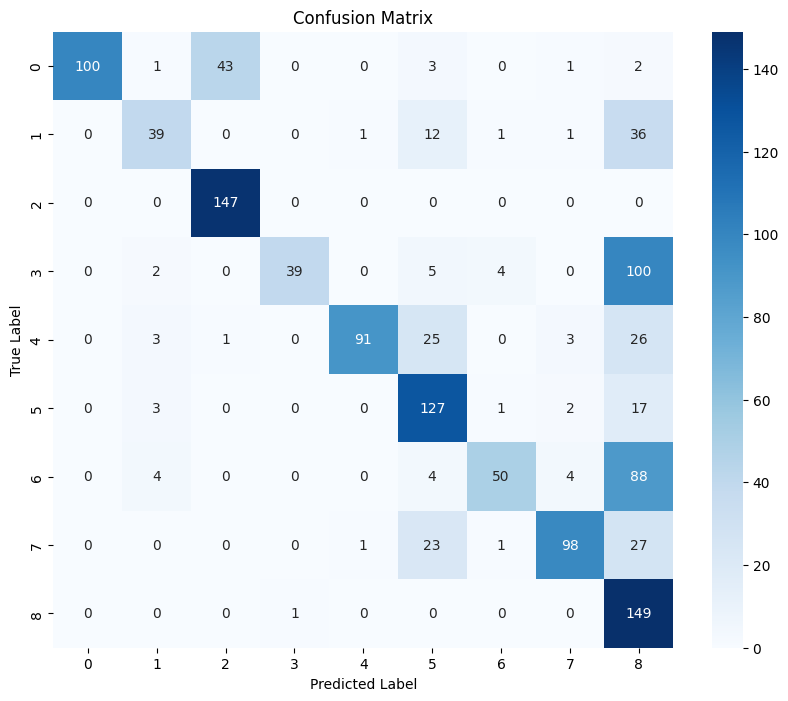

              precision    recall  f1-score   support

           0       1.00      0.67      0.80       150
           1       0.75      0.43      0.55        90
           2       0.77      1.00      0.87       147
           3       0.97      0.26      0.41       150
           4       0.98      0.61      0.75       149
           5       0.64      0.85      0.73       150
           6       0.88      0.33      0.48       150
           7       0.90      0.65      0.76       150
           8       0.33      0.99      0.50       150

    accuracy                           0.65      1286
   macro avg       0.80      0.64      0.65      1286
weighted avg       0.80      0.65      0.65      1286



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_val_true, labels_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)


## Attempt 10 - Higher batch size: Accuracy: 76%, Precision: 77%, Recall: 76%, F1: 75%

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, add, GlobalAveragePooling2D, concatenate
from keras.regularizers import l2
from keras.models import Model

# Regularization strength
reg_strength = 0.0001


# VGG19 Block
def vgg19_block(x, filters, layers, max_pool=True):
    for _ in range(layers):
        x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg_strength))(x)
    if max_pool:
        x = MaxPooling2D((2, 2))(x)
    return x

# ResNet Block
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = Activation('relu')(x)
    return x

# DenseNet Block
def densenet_block(x, growth_rate):
    bn = BatchNormalization()(x)
    act = Activation('relu')(bn)
    conv1 = Conv2D(4 * growth_rate, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    bn = BatchNormalization()(conv1)
    act = Activation('relu')(bn)
    conv2 = Conv2D(growth_rate, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    concat = concatenate([conv2, x], axis=-1)
    return concat

input_tensor = Input(shape=(256, 256, 1))

# VGG19 Part
x = vgg19_block(input_tensor, 64, 2)
x = vgg19_block(x, 128, 2)

# ResNet Part
x = residual_block(x, 128)

# DenseNet Part
x = densenet_block(x, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        xe = K.categorical_crossentropy(y_true, y_pred)
        weights = K.sum(class_weights * y_true, axis=-1)
        return K.mean(xe * weights)

    return loss

class_weights = K.constant([1.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Compile the model

model = Model(inputs=input_tensor, outputs=x)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_56 (Conv2D)             (None, 256, 256, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_56[0][0]']              
                                )                                                           

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Initialize optimizer
optimizer = Adamax(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss= weighted_loss(class_weights), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Fit the model
history = model.fit(
    image_train, labels_train,
    epochs=100,
    batch_size=16,
    validation_data=(image_val, labels_val),
    callbacks=[early_stopping]
)

Epoch 1/100
375/375 [==============================] - 25s 59ms/step - loss: 2.4408 - accuracy: 0.2008 - val_loss: 2.5846 - val_accuracy: 0.1166
Epoch 2/100
375/375 [==============================] - 21s 56ms/step - loss: 2.2532 - accuracy: 0.2882 - val_loss: 2.1867 - val_accuracy: 0.4432
Epoch 3/100
375/375 [==============================] - 21s 56ms/step - loss: 2.1223 - accuracy: 0.3538 - val_loss: 2.0011 - val_accuracy: 0.3670
Epoch 4/100
375/375 [==============================] - 21s 56ms/step - loss: 2.0620 - accuracy: 0.3722 - val_loss: 1.9142 - val_accuracy: 0.4044
Epoch 5/100
375/375 [==============================] - 21s 56ms/step - loss: 1.9750 - accuracy: 0.3967 - val_loss: 1.9095 - val_accuracy: 0.4448
Epoch 6/100
375/375 [==============================] - 21s 56ms/step - loss: 1.9232 - accuracy: 0.4160 - val_loss: 1.8644 - val_accuracy: 0.4355
Epoch 7/100
375/375 [==============================] - 21s 56ms/step - loss: 1.8639 - accuracy: 0.4403 - val_loss: 1.8189 - val_ac

41/41 [==============================] - 1s 27ms/step


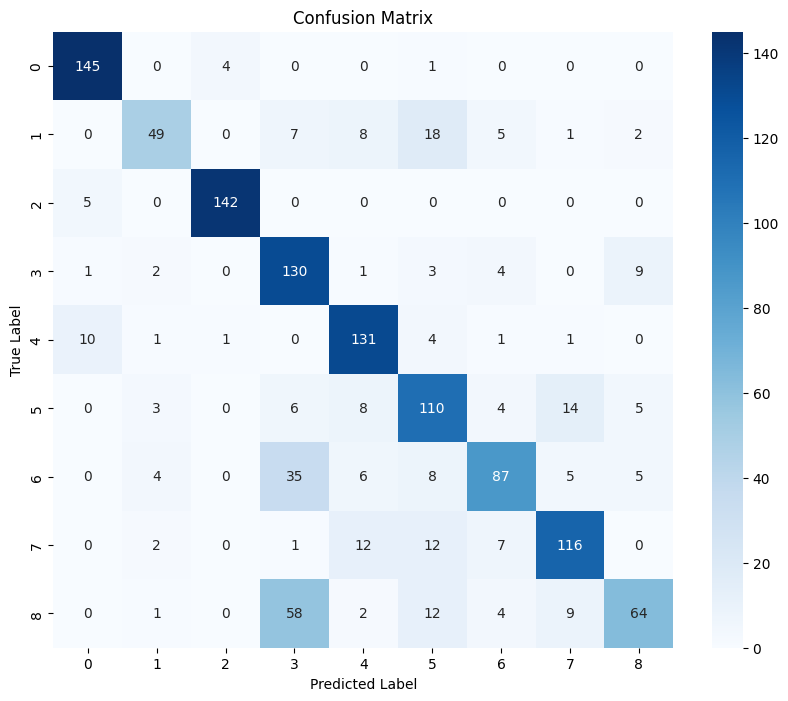

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       150
           1       0.79      0.54      0.64        90
           2       0.97      0.97      0.97       147
           3       0.55      0.87      0.67       150
           4       0.78      0.88      0.83       149
           5       0.65      0.73      0.69       150
           6       0.78      0.58      0.66       150
           7       0.79      0.77      0.78       150
           8       0.75      0.43      0.54       150

    accuracy                           0.76      1286
   macro avg       0.77      0.75      0.75      1286
weighted avg       0.77      0.76      0.75      1286



In [ ]:
# Predict the model
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_val_true, labels_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

## Attempt 11: changed learning rate and patience - Accuracy: 84%, Precision: 85%, Recall: 84%, F1: 84%

In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, add, GlobalAveragePooling2D, concatenate
from keras.regularizers import l2
from keras.models import Model

# Regularization strength
reg_strength = 0.0001


# VGG19 Block
def vgg19_block(x, filters, layers, max_pool=True):
    for _ in range(layers):
        x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg_strength))(x)
    if max_pool:
        x = MaxPooling2D((2, 2))(x)
    return x

# ResNet Block
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = Activation('relu')(x)
    return x

# DenseNet Block
def densenet_block(x, growth_rate):
    bn = BatchNormalization()(x)
    act = Activation('relu')(bn)
    conv1 = Conv2D(4 * growth_rate, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    bn = BatchNormalization()(conv1)
    act = Activation('relu')(bn)
    conv2 = Conv2D(growth_rate, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    concat = concatenate([conv2, x], axis=-1)
    return concat

input_tensor = Input(shape=(256, 256, 1))

# VGG19 Part
x = vgg19_block(input_tensor, 64, 2)
x = vgg19_block(x, 128, 2)

# ResNet Part
x = residual_block(x, 128)

# DenseNet Part
x = densenet_block(x, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        xe = K.categorical_crossentropy(y_true, y_pred)
        weights = K.sum(class_weights * y_true, axis=-1)
        return K.mean(xe * weights)

    return loss

class_weights = K.constant([1.0, 1.5, , 2.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Compile the model

model = Model(inputs=input_tensor, outputs=x)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 256, 256, 64  640         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_9 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d_8[0][0]']               
                                )                                                           

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Initialize optimizer
optimizer = Adamax(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss= weighted_loss(class_weights), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

# Fit the model
history = model.fit(
    image_train, labels_train,
    epochs=100,
    batch_size=8,
    validation_data=(image_val, labels_val),
    callbacks=[early_stopping]
)

Epoch 1/100
750/750 [==============================] - 26s 32ms/step - loss: 2.3363 - accuracy: 0.2423 - val_loss: 2.3800 - val_accuracy: 0.2947
Epoch 2/100
750/750 [==============================] - 23s 30ms/step - loss: 2.1128 - accuracy: 0.3263 - val_loss: 1.8459 - val_accuracy: 0.4075
Epoch 3/100
750/750 [==============================] - 23s 31ms/step - loss: 1.9959 - accuracy: 0.3700 - val_loss: 2.3487 - val_accuracy: 0.2325
Epoch 4/100
750/750 [==============================] - 23s 31ms/step - loss: 1.8606 - accuracy: 0.4158 - val_loss: 1.9002 - val_accuracy: 0.3981
Epoch 5/100
750/750 [==============================] - 23s 31ms/step - loss: 1.7548 - accuracy: 0.4492 - val_loss: 1.9351 - val_accuracy: 0.3663
Epoch 6/100
750/750 [==============================] - 23s 31ms/step - loss: 1.6461 - accuracy: 0.4910 - val_loss: 1.9726 - val_accuracy: 0.3771
Epoch 7/100
750/750 [==============================] - 23s 30ms/step - loss: 1.6003 - accuracy: 0.5008 - val_loss: 1.6965 - val_ac

41/41 [==============================] - 1s 26ms/step


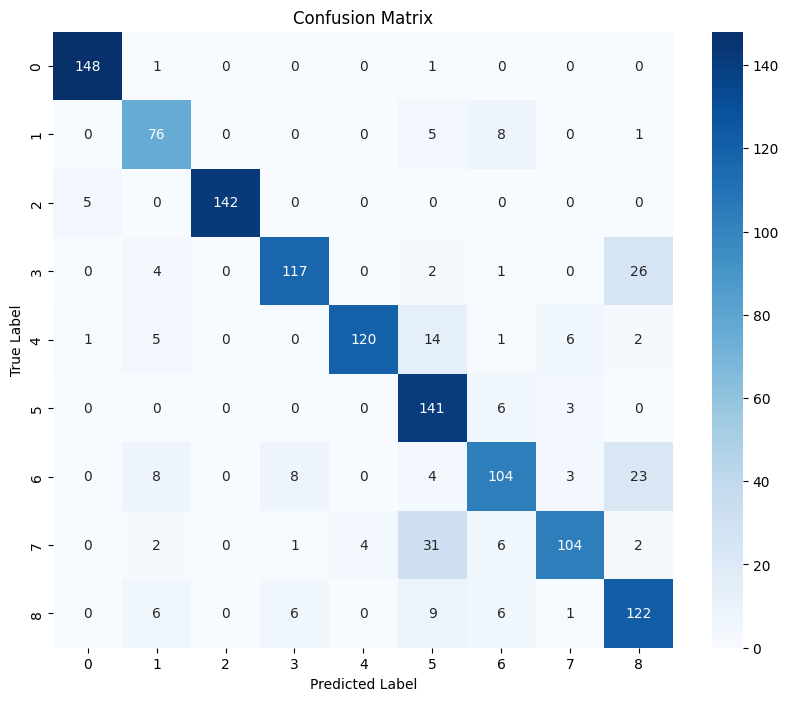

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       150
           1       0.75      0.84      0.79        90
           2       1.00      0.97      0.98       147
           3       0.89      0.78      0.83       150
           4       0.97      0.81      0.88       149
           5       0.68      0.94      0.79       150
           6       0.79      0.69      0.74       150
           7       0.89      0.69      0.78       150
           8       0.69      0.81      0.75       150

    accuracy                           0.84      1286
   macro avg       0.85      0.84      0.83      1286
weighted avg       0.85      0.84      0.84      1286



In [ ]:
# Predict the model
import seaborn as sns
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_val_true, labels_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

## Attempt 12 adjusting weights of 5 and 8 - Accuracy: 87%, Precision: 87%, Recall: 87%, F1: 87%

In [ ]:
# Regularization strength
reg_strength = 0.0001


# VGG19 Block
def vgg19_block(x, filters, layers, max_pool=True):
    for _ in range(layers):
        x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(reg_strength))(x)
    if max_pool:
        x = MaxPooling2D((2, 2))(x)
    return x

# ResNet Block
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same', kernel_regularizer=l2(reg_strength))(x)
    x = BatchNormalization()(x)
    x = add([shortcut, x])
    x = Activation('relu')(x)
    return x

# DenseNet Block
def densenet_block(x, growth_rate):
    bn = BatchNormalization()(x)
    act = Activation('relu')(bn)
    conv1 = Conv2D(4 * growth_rate, (1, 1), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    bn = BatchNormalization()(conv1)
    act = Activation('relu')(bn)
    conv2 = Conv2D(growth_rate, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(reg_strength))(act)
    concat = concatenate([conv2, x], axis=-1)
    return concat

input_tensor = Input(shape=(256, 256, 1))

# VGG19 Part
x = vgg19_block(input_tensor, 64, 2)
x = vgg19_block(x, 128, 2)

# ResNet Part
x = residual_block(x, 128)

# DenseNet Part
x = densenet_block(x, 32)

x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(reg_strength))(x)
x = Dropout(0.5)(x)
x = Dense(9, activation='softmax')(x)

def weighted_loss(class_weights):
    def loss(y_true, y_pred):
        xe = K.categorical_crossentropy(y_true, y_pred)
        weights = K.sum(class_weights * y_true, axis=-1)
        return K.mean(xe * weights)

    return loss

class_weights = K.constant([1.0, 1.5, 1.0, 2.0, 1.5, 1.0, 1.0, 1.5, 1.0])

# Compile the model

model = Model(inputs=input_tensor, outputs=x)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 64  640         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_16[0][0]']              
                                )                                                           

In [ ]:
from keras.optimizers import Adamax
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

# Initialize optimizer
optimizer = Adamax(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss= weighted_loss(class_weights), metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)

# Fit the model
history = model.fit(
    image_train, labels_train,
    epochs=100,
    batch_size=8,
    validation_data=(image_val, labels_val),
    callbacks=[early_stopping]
)

Epoch 1/100
750/750 [==============================] - 24s 31ms/step - loss: 0.2816 - accuracy: 0.9550 - val_loss: 0.7358 - val_accuracy: 0.8453
Epoch 2/100
750/750 [==============================] - 22s 29ms/step - loss: 0.2567 - accuracy: 0.9632 - val_loss: 0.6793 - val_accuracy: 0.8663
Epoch 3/100
750/750 [==============================] - 22s 30ms/step - loss: 0.2417 - accuracy: 0.9680 - val_loss: 0.6658 - val_accuracy: 0.8709
Epoch 4/100
750/750 [==============================] - 22s 30ms/step - loss: 0.2360 - accuracy: 0.9693 - val_loss: 0.6711 - val_accuracy: 0.8670
Epoch 5/100
750/750 [==============================] - 22s 29ms/step - loss: 0.2225 - accuracy: 0.9745 - val_loss: 0.6770 - val_accuracy: 0.8678
Epoch 6/100
750/750 [==============================] - 22s 30ms/step - loss: 0.2251 - accuracy: 0.9717 - val_loss: 0.7282 - val_accuracy: 0.8709
Epoch 7/100
750/750 [==============================] - 22s 30ms/step - loss: 0.2223 - accuracy: 0.9723 - val_loss: 0.6774 - val_ac

41/41 [==============================] - 1s 26ms/step


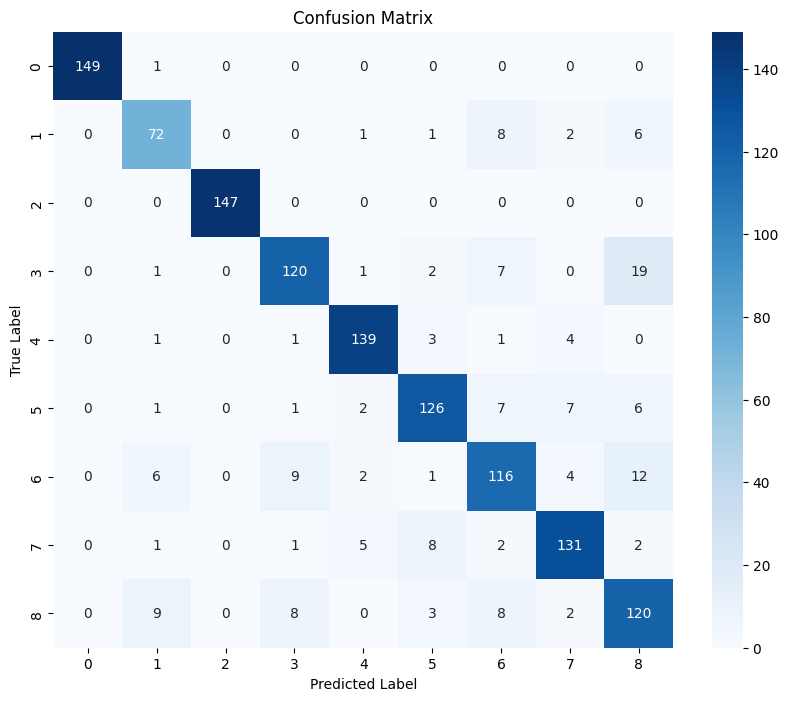

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.78      0.80      0.79        90
           2       1.00      1.00      1.00       147
           3       0.86      0.80      0.83       150
           4       0.93      0.93      0.93       149
           5       0.88      0.84      0.86       150
           6       0.78      0.77      0.78       150
           7       0.87      0.87      0.87       150
           8       0.73      0.80      0.76       150

    accuracy                           0.87      1286
   macro avg       0.87      0.87      0.87      1286
weighted avg       0.87      0.87      0.87      1286



In [ ]:
# Predict the model
import seaborn as sns
labels_val_pred = model.predict(image_val)
# Convert to class labels with np.argmax
labels_val_pred = np.argmax(labels_val_pred, axis=1)
# Convert real labels with np.argmax
labels_val_true = np.argmax(labels_val, axis=1)

# Create the confusion matrix
confusion_mtx = confusion_matrix(labels_val_true, labels_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Make the classification report
report = classification_report(labels_val_true, labels_val_pred)
# Print report
print(report)

In [ ]:
# Save model weights to HDF5 file
model.save_weights('cnn_model_weights.h5')
 # Load the weights from the HDF5 file
model.load_weights('cnn_model_weights.h5')

In [ ]:
model.save('cnn_model.h5')

In [ ]:
path_to_save = '/content/drive/My Drive/model_weights.h5'
model.save_weights(path_to_save)